# GAN to generate images of Cats



In [14]:
# Ignore warning messages
import warnings
warnings.filterwarnings("ignore")

In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
# Import all dependencies
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization

In [15]:
# Mount dataset from drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Define dataset path
data_path = "/content/drive/MyDrive/ImageGen/Cat_faces"
# Object to load images
images = []
# Input noise dimension
input_dim = 100

array([[[114, 146, 165],
        [120, 152, 171],
        [ 90, 123, 142],
        ...,
        [ 26,  53,  67],
        [ 13,  46,  62],
        [ 14,  50,  66]],

       [[ 68,  97, 118],
        [ 58,  89, 110],
        [100, 133, 153],
        ...,
        [ 11,  37,  53],
        [ 95, 125, 142],
        [ 84, 118, 134]],

       [[130, 154, 182],
        [110, 139, 166],
        [ 92, 126, 150],
        ...,
        [ 45,  70,  86],
        [ 42,  70,  87],
        [ 71, 101, 118]],

       ...,

       [[ 80, 114, 107],
        [ 76, 110, 104],
        [ 43,  78,  74],
        ...,
        [146, 161, 153],
        [129, 142, 126],
        [156, 169, 147]],

       [[ 91, 137, 115],
        [ 80, 126, 104],
        [ 57, 103,  80],
        ...,
        [ 90, 104, 103],
        [ 84,  97,  89],
        [144, 156, 144]],

       [[ 63, 112,  84],
        [ 91, 141, 111],
        [ 99, 149, 117],
        ...,
        [144, 157, 159],
        [ 88,  99,  97],
        [101, 111, 105]]], dtype=uint8)
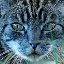

In [17]:
sample_path = os.path.join(data_path, "cat_1.png")
sample_img = cv2.imread(sample_path)
sample_img

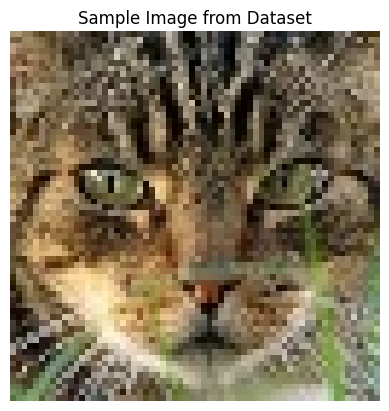

In [18]:
# Display sample input
sample_path = os.path.join(data_path, "cat_1.png")
sample_img = cv2.imread(sample_path) # Read path of image
sample_img = cv2.cvtColor(sample_img,cv2.COLOR_BGR2RGB) # Convert colour space from BGR to RGB

plt.imshow(sample_img)
plt.title("Sample Image from Dataset")
plt.axis("off")
plt.show()

In [19]:
# Load dataset
for x in os.listdir(data_path):
  img = cv2.imread(os.path.join(data_path, x))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Change colour space from BGR to GRAY
  images.append(img)

KeyboardInterrupt: 

In [ ]:
# Shape of dataset
image_array = np.array(images)
image_array.shape

In [ ]:
# Sample image after loading
plt.imshow(image_array[777])
plt.show()

In [12]:
# Data preprocessing - Normalize all the images to the range [-1,1] for tanh activation
image_array = (image_array - 127.5)/127.5
print("Minimum: ", image_array.min(), " Maximum: ", image_array.max())

Minimum:  -1.0  Maximum:  1.0


In [13]:
# Show what the dataset looks like
image_array

array([[[ 0.45098039,  0.48235294,  0.54509804, ...,  0.82745098,
          0.89019608,  0.88235294],
        [ 0.31764706,  0.36470588,  0.49019608, ...,  0.85882353,
          0.81176471,  0.83529412],
        [ 0.3254902 ,  0.27058824,  0.40392157, ...,  0.90588235,
          0.81960784,  0.79607843],
        ...,
        [ 0.12941176, -0.30980392, -0.45098039, ...,  0.52941176,
          0.63921569, -0.02745098],
        [-0.02745098, -0.1372549 , -0.38823529, ...,  0.28627451,
          0.5372549 , -0.10588235],
        [ 0.01960784, -0.18431373, -0.21568627, ...,  0.49019608,
          0.38039216,  0.23137255]],

       [[-0.31764706, -0.33333333, -0.30980392, ..., -0.61568627,
         -0.64705882, -0.6627451 ],
        [-0.34901961, -0.3254902 , -0.33333333, ..., -0.6627451 ,
         -0.67843137, -0.68627451],
        [-0.23137255, -0.27058824, -0.22352941, ..., -0.67843137,
         -0.67058824, -0.67843137],
        ...,
        [ 0.09019608,  0.0745098 ,  0.09019608, ...,  

In [18]:
# Define generator model

# Input noise shape for the generator
noise_shape = (input_dim,)

# Sequential() model forms the backbone of the model into which other layers can be added
gen = Sequential(
    [
        Dense(256 * 8 * 8 , input_shape = noise_shape), # Dense layer with initial noise input
        Reshape((8, 8, 256)), # Preparing input noise for transposed convolution
        LeakyReLU(0.2),
        BatchNormalization(),

        Conv2DTranspose(128, kernel_size = (3,3), strides = (2,2), padding = 'same', activation = 'tanh'),
        #LeakyReLU(0.2),
        BatchNormalization(),

        Conv2DTranspose(64, kernel_size = (3,3), strides = (2,2), padding = 'same', activation = 'tanh'),
        #LeakyReLU(0.2),
        BatchNormalization(),

        Conv2DTranspose(1, kernel_size = (3,3), strides = (2,2), padding = 'same', activation = 'sigmoid')
    ]
)

# Generator does not have to be compiled because it is not trained directly. It is compiled and trained through the combined GAN model
# I have it compiled here to get a model summary
gen.compile(optimizer = 'adam', loss = 'binary_crossentropy')
gen.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1654784   
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 8, 256)         0         
                                                                 
 batch_normalization (Batch  (None, 8, 8, 256)         1024      
 Normalization)                                                  
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       295040    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 128)       5

In [19]:
# Define discriminator model

# Input shape of actual image in the dataset
input_shape = (64, 64, 1)

# Sequential() model forms the backbone of the model into which other layers can be added
disc = Sequential(
    [
        Conv2D(64, kernel_size = (3,3), strides = (2,2), padding = 'same', activation = 'tanh', input_shape = input_shape), # Dense layer with initial input - image from dataset
        #LeakyReLU(0.2),

        Conv2D(128, kernel_size = (3,3), strides = (2,2), padding = 'same', activation = 'tanh'),
        #LeakyReLU(0.2),

        Flatten(),

        Dense(1, activation = 'sigmoid')
    ]
)

# Discriminator has to be compiled
disc.compile(optimizer = 'adam', loss = 'binary_crossentropy')
disc.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 32769     
                                                                 
Total params: 107265 (419.00 KB)
Trainable params: 107265 (419.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
# Create GAN model with generator and discrimator models

disc.trainable = False
gan_input = Input(noise_shape) # gan_input is for the genrator and is a noise vector
gen_image = gen(gan_input) # This noise is used to generate image
gan_output = disc(gen_image) # gan_output is the genrated image and is used as input for the discriminator

# the GAN model is built using the outputs of both generator and discriminator
gan = Model(gan_input, gan_output)
gan.compile(optimizer = 'adam', loss = 'binary_crossentropy')
gan.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 1)         2025985   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 107265    
                                                                 
Total params: 2133250 (8.14 MB)
Trainable params: 2025089 (7.73 MB)
Non-trainable params: 108161 (422.50 KB)
_________________________________________________________________


In [21]:
# Inputs are trained in batches to manage computaional resources
batch_size = 64
no_of_batches = int(image_array.shape[0]/batch_size)

# An epoch is the combination of forward and backward propagation. GANs usually require higher epochs during training for better quality of generation
epochs = 2000

In [22]:
# Function to plot generated image
def plot(samples, epoch):
  sample_noise = np.random.normal(0, 1, (samples, input_dim)) # Input noise taken from normal distribution
  gen_image = gen.predict(noise)
  plt.figure(figsize = (10,1))
  for i in range(samples):
    plt.subplot(1, samples, i+1)
    plt.imshow(gen_image[i]*127.5 + 127.5, cmap = 'gray')
    plt.axis("off")
  plt.title(f"Images generated at Epoch {epoch+1}: ")
  plt.show()


In [23]:
# Train GAN - training loop

# Input noise taken from normal distribution
noise = np.random.normal(0, 1, (batch_size, input_dim))
# Initialize list of loss for discriminator and generator
d_loss = []
g_loss = []

# Start time for training
start_time = time.time()

for epoch in range(epochs):

  # Discriminator and generator loss per epoch
  epoch_d_loss = 0.0
  epoch_g_loss = 0.0

  for step in range(no_of_batches):

    # Begin discriminator training
    # Discriminator training is set to true
    disc.trainable = True

    # Give an id to each image in batch
    idx = np.random.randint(0, image_array.shape[0], batch_size)
    # Generate real and fake images
    real_images = image_array[idx]
    fake_images = gen.predict(noise)

    # Define lable for real(1) and fake (0) data
    real_labels = np.ones((batch_size, 1)) # These labels can be multiplied by 0.95 to prevent discriminator from becoming too confident in predicting real data
    fake_labels = np.zeros((batch_size, 1))

    # Calculate discriminator loss for real and fake data
    d_loss_real = disc.train_on_batch(real_images, real_labels)
    d_loss_fake = disc.train_on_batch(fake_images, fake_labels)
    # The discriminator loss is a comnation of loss for real and fake data
    avg_d_loss = (0.5 * d_loss_real) + (0.5 * d_loss_fake)
    epoch_d_loss += avg_d_loss

    # begin generator training
    # Set driscriminator training to False to pause discriminator training in favour of generator training
    disc.trainable = False

    # Generate labels for generator images
    gan_labels = np.ones((batch_size, 1))
    # Calculate generator loss
    epoch_g_loss += gan.train_on_batch(noise, gan_labels)

  # Append the losses per epoch into list of  losses for both discriminator and generator
  d_loss.append(epoch_d_loss/no_of_batches)
  g_loss.append(epoch_g_loss/no_of_batches)

  # Print loss every 25 epochs
  if (epoch+1)%50 == 0:
    print(f"Epoch: {epoch+1}/{epochs}, d_loss: {d_loss[epoch]}, g_loss: {g_loss[epoch]} ")

  # Every 100 epochs, show 10 samples of generated images
  if (epoch+1)%100 == 0:

    samples = 10
    plot(samples, epoch)

# End time for training
end_time = time.time()

# Calculate training time
min = int((end_time - start_time)/60)
sec =int((end_time - start_time))%60

# Display totla time taken for training
print(f"Total time taken: {min} minutes {sec} seconds")


Output hidden; open in https://colab.research.google.com to view.

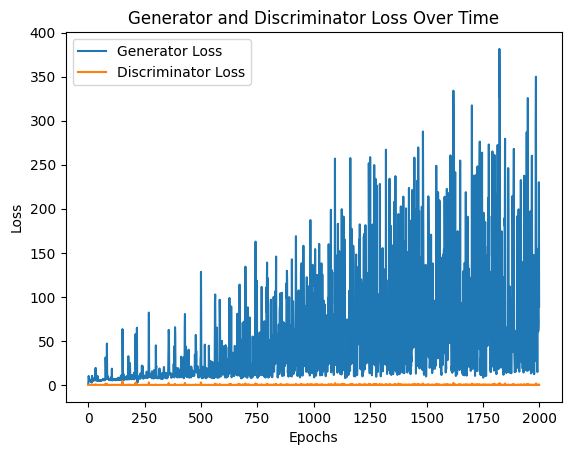

In [24]:
# Plot generator and discriminator loss
plt.plot(g_loss, label='Generator Loss')
plt.plot(d_loss, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss Over Time')
plt.legend()
plt.show()

In [25]:
# save models
gen.save("generator.h5")
disc.save("discriminator.h5")
gan.save("gans.h5")

# download saved models
from google.colab import files

files.download("generator.h5")
files.download("discriminator.h5")
files.download("gans.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
# Later, when you want to retrain the model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/ImageGen/gans.h5')
gen=loaded_model
# Compile the GAN model
#loaded_model.compile(optimizer='adam', loss='binary_crossentropy')  # Adjust optimizer and loss as needed

# Load your new dataset for retraining (assuming you have a new dataset)
#new_dataset = ...  # Load your new dataset here

# Continue training the GAN model on the new dataset
#gan_model.fit(new_dataset, epochs=10)  # Adjust the number of epochs as needed

In [23]:
# save generated image output
input_dim=100
noise = np.random.normal(0, 1, (10, input_dim))
samples = 10
sample_noise = np.random.normal(0, 1, (samples, input_dim))
gen_image = gen.predict(noise)

# Check the shape of gen_image
print(gen_image.shape)

# Reshape gen_image if necessary
if len(gen_image.shape) == 1:
    gen_image = gen_image.reshape((samples, input_dim))

plt.figure(figsize = (10,1))
plt.show()

1/1 [==============================] - 0s 72ms/step
(10, 1)


<Figure size 1000x100 with 0 Axes>

In [ ]:
# save generated image output
input_dim=100
noise = np.random.normal(0, 1, (10, input_dim))
samples = 10
sample_noise = np.random.normal(0, 1, (samples, input_dim))
gen_image = gen.predict(noise)
plt.figure(figsize = (10,1))
for i in range(samples):
  gen_image[i] = gen_image[i]*127.5 + 127.5
  #gen_image[i] = cv2.cvtColor(gen_image[i], cv2.COLOR_BGR2RGB)
  plt.savefig(f"generated_cat_{i+1}.png")
  plt.subplot(1, samples, i+1)
  plt.imshow(gen_image[i])
  plt.axis("off")
plt.title("Output: ")
plt.show()


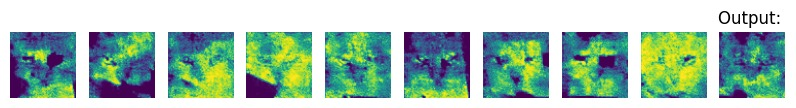

In [37]:
from google.colab import files
for i in range(20):
  files.download(f"generated_cat_{i+1}.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>